In [1]:
import pickle
import numpy as np
import networkx as nx
import pandas as pd
import brainmaptools as brainmap
import matplotlib.pyplot as plt
import community
import brainx.modularity as mod
import operator
%matplotlib inline
import csv
import scipy as scipy
import scipy.io as io
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import math as math
import pylab as pl
import My_functions as myfunctions
from tqdm import tqdm
import time
from collections import Counter
import random
from collections import OrderedDict

/Users/owner/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/brainx/__init__.py:30: UserWarning: Monkeypatching NetworkX's Watts-Strogatz routine
  warnings.warn("Monkeypatching NetworkX's Watts-Strogatz routine")


In [2]:
domains= ['Memory', 'Working Memory', 'Emotion', 'Attention', 'Language', 'Vision', 'Audition', 'Base','Rest']

In [3]:
relabel_dict_file='/Users/owner/PFC_MetaConnectome/Scripts/Label_dict.pck'
relabel_dict=pickle.load(open(relabel_dict_file,"rb"))

In [4]:
G_nothresh={}
for x in domains:
    filename='G_nothresh_jaccard_'+x+'_.pck'
    workdir='/Users/owner/PFC_MetaConnectome/Results/G_jaccard_graphs/Unthresholded_G_jaccard/'
    output=workdir+filename
    G_nothresh[x]=pickle.load(open (output, 'rb'))

In [5]:
#remove Base and Rest From domains
domains = [x for x in domains if x not in ['Base','Rest']]

# Basic Metrics

In [6]:
basic_metrics={x: brainmap.run_weighted_metrics(G_nothresh[x], 12, comm=False) for x in domains}

Singificant Nodes in One Domain

In [7]:
significant_nodes, z_overall=myfunctions.significant_regions(basic_metrics, domains, 'between_cent', relabel_dict, 1.96)

In [8]:
top5_sig = {}
for x in domains:
    cent_list = []
    for n in range(5):
        cent_list.append(sorted(significant_nodes[x], key = lambda node:node[2])[-5:][n][0])
    top5_sig[x] = cent_list

In [9]:
top5_df = pd.DataFrame.from_dict(top5_sig)
top5_df

,Attention,Audition,Emotion,Language,Memory,Vision,Working Memory
0,Frontal_Inf_Oper_R_3,Cingulum_Ant_L_2,Frontal_Sup_Medial_L_5,Frontal_Inf_Tri_L_4,Frontal_Inf_Tri_R_4,Precentral_R_8,Supp_Motor_Area_R_4
1,Supp_Motor_Area_L_3,Frontal_Inf_Oper_R_1,Frontal_Inf_Tri_L_1,Supp_Motor_Area_L_4,Frontal_Inf_Tri_R_1,Supp_Motor_Area_R_7,Frontal_Inf_Tri_R_1
2,Frontal_Inf_Oper_L_2,Supp_Motor_Area_L_7,Supp_Motor_Area_R_4,Supp_Motor_Area_L_7,Frontal_Inf_Oper_L_2,Precentral_R_6,Frontal_Mid_R_8
3,Supp_Motor_Area_R_4,Precentral_R_8,Frontal_Inf_Orb_L_6,Frontal_Inf_Tri_R_1,Frontal_Sup_Medial_L_6,Frontal_Sup_L_2,Supp_Motor_Area_L_7
4,Precentral_L_4,Supp_Motor_Area_L_4,Frontal_Mid_L_2,Frontal_Inf_Oper_L_2,Supp_Motor_Area_L_4,Supp_Motor_Area_R_4,Frontal_Inf_Oper_L_2


Probabilistically Significant Betweeness Centrality Nodes

In [10]:
N={x: float(G_nothresh[x].number_of_nodes()) for x in domains}
P={}
spots=len(basic_metrics[x]['topbetween_cent'])
for x in domains:
    P[x]=(spots/N[x])*((spots-1)/(N[x]-1))*((spots-2)/(N[x]-2))*((spots-3)/(N[x]-3))*((spots-4)/(N[x]-4))*((spots-5)/(N[x]-5))*((spots-6)/(N[x]-6))*((spots-7)/(N[x]-7))*((spots-8)/(N[x]-8))*((spots-9)/(N[x]-9))*((spots-10)/(N[x]-10))*((spots-11)/(N[x]-11))
    #P[x]="{:.0%}".format(P[x])

In [11]:
P['Memory']*P['Working Memory']*P['Language']*P['Audition']*P['Attention']

9.2056864801897e-96

In [12]:
top_freq=[(basic_metrics[x]['topbetween_cent']) for x in domains]

In [13]:
top_list=[item for sublist in top_freq for item in sublist]

In [14]:
for x in domains:
    for n in range(len(significant_nodes[x])):
        if significant_nodes[x][n][0] not in top_list:
            print significant_nodes[x][n][0], x

In [15]:
top_freq_dict=Counter(top_list)

In [16]:
sorted_top_freq=sorted(top_freq_dict.items(), key=operator.itemgetter(1), reverse=True)

In [17]:
degree_specialized_regions=[]
for part in range(len(sorted_top_freq)):
    for section in range(len(top_freq)):
        for x in domains:
            for n in range(len(significant_nodes[x])):
                if sorted_top_freq[part][0] == significant_nodes[x][n][0]:
                    if sorted_top_freq[part][1] < 2:
                        degree_specialized_regions.append((x,sorted_top_freq[part][0]))
degree_specialized_regions=set(degree_specialized_regions)

In [18]:
between_specialized_regions=[]
for part in range(len(sorted_top_freq)):
    for section in range(len(top_freq)):
        for x in domains:
            for n in range(len(significant_nodes[x])):
                if sorted_top_freq[part][0] == significant_nodes[x][n][0]:
                    if sorted_top_freq[part][1] < 2:
                        between_specialized_regions.append((x,sorted_top_freq[part][0]))
between_specialized_regions=set(between_specialized_regions)

### Create BrainNet file for Betweeness Centrality Specialized Regions

In [19]:
path = '/Users/owner/Documents/MATLAB/Add_Ons/BrainNetViewer_20171031/Data/NodeFiles/CSV/Label_coordinates.csv'
df = pd.read_csv(path, header=None, names=['x','y','z','regions'], sep='\t')
df.insert(4,'module',0,True)
df.insert(5,'size',0,True)
df.insert(6,'nodes',0,True)
df=df[['x','y','z','module','size','regions','nodes']]

In [24]:
for region in between_specialized_regions:
    print (region[0], domains.index(region[0]))

('Audition', 6)
('Language', 4)
('Emotion', 2)
('Emotion', 2)
('Vision', 5)
('Attention', 3)
('Emotion', 2)
('Emotion', 2)
('Attention', 3)
('Working Memory', 1)
('Emotion', 2)
('Vision', 5)
('Audition', 6)
('Emotion', 2)


In [123]:
for region in between_specialized_regions:
    for n in range(len(df)):
        if region[1] == df.loc[n,'regions']:
            df.loc[n,'nodes'] = region[1]
            df.loc[n, 'module'] = domains.index(region[0])
            df.loc[n, 'size'] = 1
df=df[['x','y','z','module','size','nodes']]
df=df[df.nodes != 0]
df.index=range(len(df))

In [127]:
df_left = df.copy()
df_right = df.copy()
for n,node in enumerate(df['nodes']):
    if '_L_' not in node:
        df_left.loc[n,'nodes'] = 0
    elif '_R_' not in node:
        df_right.loc[n,'nodes'] = 0
        
#seperate right and left for clearer images
df_left = df_left[df_left.nodes != 0]
df_right = df_right[df_right.nodes !=0]

In [132]:
outdir='/Users/owner/Documents/MATLAB/Add_Ons/BrainNetViewer_20171031/Data/NodeFiles/CSV/'
df_left.to_csv(outdir+'L_Between_Special.csv', header=False, index=False, index_label=False)
df_right.to_csv(outdir+'R_Between_Special.csv', header=False, index=False, index_label=False)

In [133]:
for side in ['L','R']:
    csv_file = '/Users/owner/Documents/MATLAB/Add_Ons/BrainNetViewer_20171031/Data/NodeFiles/CSV/'+side+'_Between_Special.csv'
    txt_file = '/Users/owner/Documents/MATLAB/Add_Ons/BrainNetViewer_20171031/Data/NodeFiles/'+side+'_Between_Special.node'
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()

In [58]:
specialized_regions=[]
for region in degree_specialized_regions:
    for reg in between_specialized_regions:
        if region == reg:
            specialized_regions.append(region[1])

In [59]:
for n in specialized_regions:
    print n[0], n[1]

P r
F r
F r
F r
S u
P r
F r
F r
P r
P r
F r


In [60]:
stable_regions=[]
for n in range(len(sorted_top_freq)):
    if sorted_top_freq[n][1] > 5:
        stable_regions.append(sorted_top_freq[n][0])

# Fingerprints

In [19]:
metric_l=('degree_cent','between_cent','eigenvector_cent','degrees','ccoeff')

In [ ]:
Mid_regions = [relabel_dict[x] for x in relabel_dict if 'Frontal_Mid_L' in relabel_dict[x] ]

In [20]:
relabel_dict

{0: 'Cingulum_Ant_R_1',
 1: 'Frontal_Mid_L_13',
 2: 'Frontal_Mid_L_14',
 3: 'Frontal_Mid_L_15',
 4: 'Frontal_Mid_L_16',
 5: 'Frontal_Mid_L_17',
 6: 'Frontal_Mid_L_18',
 7: 'Frontal_Mid_L_19',
 8: 'Frontal_Mid_Orb_L_1',
 9: 'Frontal_Mid_Orb_L_2',
 10: 'Frontal_Mid_Orb_L_3',
 11: 'Frontal_Mid_Orb_L_4',
 12: 'Frontal_Mid_Orb_R_1',
 13: 'Frontal_Mid_Orb_R_2',
 14: 'Frontal_Mid_Orb_R_3',
 15: 'Frontal_Mid_Orb_R_4',
 16: 'Frontal_Mid_R_1',
 17: 'Frontal_Mid_R_2',
 18: 'Frontal_Mid_R_3',
 19: 'Frontal_Mid_R_4',
 20: 'Frontal_Mid_R_5',
 21: 'Frontal_Mid_R_6',
 22: 'Frontal_Mid_R_7',
 23: 'Frontal_Mid_R_8',
 24: 'Frontal_Mid_R_9',
 25: 'Frontal_Mid_R_10',
 26: 'Frontal_Mid_R_11',
 27: 'Frontal_Mid_R_12',
 28: 'Frontal_Mid_R_13',
 29: 'Frontal_Mid_R_14',
 30: 'Frontal_Mid_R_15',
 31: 'Frontal_Mid_R_16',
 32: 'Frontal_Mid_R_17',
 33: 'Frontal_Mid_R_18',
 34: 'Frontal_Mid_R_19',
 35: 'Frontal_Mid_R_20',
 36: 'Frontal_Sup_L_1',
 37: 'Frontal_Sup_L_2',
 38: 'Frontal_Sup_L_3',
 39: 'Frontal_Sup_L_4',

In [51]:
#grab top nodes from each sub region in the task general network
sort_genNodes = sorted(basic_metrics['Base']['between_cent'].items(), key = lambda x: x[1], reverse = True)
genNode_cent = OrderedDict(sort_genNodes)

In [64]:
all_SubReg = ['Precentral','Frontal_Sup','Frontal_Mid','Supp_Motor_Area','Rectus','Frontal_Sup_Medial',
             'Frontal_Inf_Orb', 'Frontal_Med_Orb', 'Cingulum_Ant', 'Frontal_Sup_Orb','Frontal_Inf_Tri',
             'Rolandic_Oper', 'Frontal_Inf_Oper']

In [80]:
import re

In [120]:
highests_SubReg  = []
for node in genNode_cent.keys():
    if re.split('_L',node)[0] in all_SubReg:
        if not any([x for x in highests_SubReg if re.search(re.split('_L|_R',node)[0],x)]):
            highests_SubReg.append(node)

Centrality Fingerprints

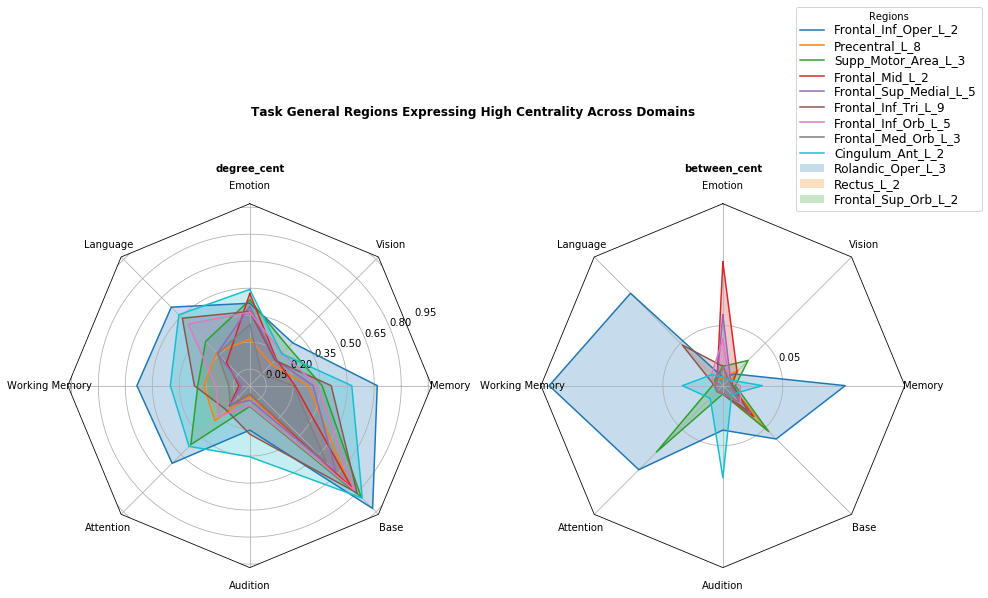

In [122]:
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

regionlist = highests_SubReg

#regionlist=['Frontal_Inf_Oper_R_3', 'Frontal_Inf_Oper_R_1', 'Supp_Motor_Area_R_2', 
            #'Precentral_L_8', 'Frontal_Inf_Orb_L_5', 'Precentral_L_11', 'Precentral_R_14']

if __name__ == '__main__':
    N = len(domains)
    theta = brainmap.radar_factory(N, frame='polygon')

    data = brainmap.make_fingerprint_data(regionlist, basic_metrics.keys(), basic_metrics, metric_l)
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(15, 15), nrows=1, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.3, hspace=0.10, top=0.55, bottom=0.05)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
              'tab:pink', 'tab:gray', 'tab:cyan']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids(np.arange(0.05, 1.0, 0.15))
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.08),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        # add legend relative to top-left plot
    ax = axes[0]
    labels = (regionlist)
    legend = ax.legend(labels, loc=(2.0, .98),
                       labelspacing=0.2, title='Regions', fontsize='large')

    fig.text(0.5, 0.55, 'Task General Regions Expressing High Centrality Across Domains',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    fig.savefig('/Users/owner/Desktop/L_TaskGenFP.png')

    plt.show()

Domain Fingerprints

In [ ]:
def domain_fingerprints (region_list, domain_list, metric_dict, metric_tuple):
    data=[[] for l in range(len(metric_tuple)+1)]
    for region in region_list:
        for metric in metric_tuple:
            for x in domain_list:
                if region not in metric_dict[x][metric].keys():
                    metric_dict[x][metric].update({region: 0})
    measure_dict={metric: {x: {region: metric_dict[x][metric][region] for region in region_list} for x in domain_list} for metric in metric_tuple}
    data_raw=[[OrderedDict(measure_dict[metric][x]).values() for x in domain_list] for metric in metric_tuple]
    data_tuple=tuple((metric, data_raw[n]) for n in range(len(data_raw)) for metric in metric_tuple)
    data[0] = OrderedDict(measure_dict[metric][x]).keys()
    data[1]=data_tuple[0]
    data[2]=data_tuple[6]
    data[3]=data_tuple[12]
    data[4]=data_tuple[18]
    data[5]=data_tuple[24]
    
    return data

In [ ]:
metric_l = ('degree_cent','between_cent','eigenvector_cent','degrees','ccoeff')
regionlist=['Frontal_Mid_L_14', 'Frontal_Inf_Oper_L_4', 'Frontal_Med_Orb_L_3', 
            'Frontal_Mid_Orb_L_4','Rectus_L_1','Precentral_L_5', 'Supp_Motor_Area_L_9']
if __name__ == '__main__':
    N = 7
    theta = brainmap.radar_factory(N, frame='polygon')

    data = domain_fingerprints(regionlist, basic_metrics.keys(), basic_metrics, metric_l)
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(15, 15), nrows=1, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.4, hspace=0.10, top=0.55, bottom=0.05)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
              'tab:pink', 'tab:gray', 'tab:cyan']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids(np.arange(0.05, 1.0, 0.15))
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.08),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        # add legend relative to top-left plot
    ax = axes[0]
    labels = (basic_metrics.keys())
    legend = ax.legend(labels, loc=(2.1, .98),
                       labelspacing=0.2, title='Domain', fontsize='large')

    fig.text(0.5, 0.55, 'Domains Across PFC Subregions',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    fig.savefig('/Users/owner/Desktop/Domain_PFC_Subregs.png')

    plt.show()

# Merge Subregions 

In [ ]:
G_merge = {}
for x in tqdm(domains):
    G_merge[x] = G_nothresh[x].copy()
    for node1 in G_merge[x].nodes():
        for node2 in G_merge[x].nodes():
            if node1 != node2:
                if node1.translate(None, '0123456789') == node2.translate(None, '0123456789'):
                    G_merge[x] = nx.contracted_nodes(G_merge[x],node1,node2,self_loops=False)

In [ ]:
merge_labels = {x: {G_merge[x].nodes()[i]: G_merge[x].nodes()[i].translate(None, '0123456789')[:-1] for i in range(len(G_merge[x].nodes()))} for x in domains}

In [ ]:
for x in domains:
    filename = 'G_merged_'+x+'_.pck'
    workdir = '/Users/owner/Functional_Connectivity/Results/G_jaccard_graphs/Unthresholded_G_jaccard/'
    output = workdir + filename
    G_merge[x] = nx.relabel_nodes(G_merge[x],merge_labels[x], copy = False)
    #pickle.dump(G_merge[x], open (output, 'wb'))

## Run Basic Metrics on Merged Graph 

In [ ]:
G_merge = {}
for x in domains:
    filename = 'G_merged_'+x+'_.pck'
    workdir = '/Users/owner/Functional_Connectivity/Results/G_jaccard_graphs/Unthresholded_G_jaccard/Merged_Graphs/'
    output = workdir + filename
    G_merge[x] = pickle.load(open (output, 'rb'))

In [ ]:
basic_metrics_merge={x: brainmap.run_weighted_metrics(G_merge[x], 12, comm=False) for x in domains}

#pickle.dump(basic_metric_merge, open('/Users/owner/Functional_Connectivity/Results/G_jaccard_graphs/Unthresholded_G_jaccard/Merged_Graphs/Merge_metrics.pck','wb'))

In [ ]:
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

regionlist=['Frontal_Mid_L', 'Frontal_Inf_Oper_L', 'Frontal_Med_Orb_L', 
            'Frontal_Mid_Orb_L','Rectus_L','Precentral_L', 'Supp_Motor_Area_L']
if __name__ == '__main__':
    N = 9
    theta = brainmap.radar_factory(N, frame='polygon')

    data = brainmap.make_fingerprint_data(regionlist, basic_metrics_merge.keys(), basic_metrics_merge, metric_l)
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(15, 15), nrows=1, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.3, hspace=0.10, top=0.55, bottom=0.05)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
              'tab:pink', 'tab:gray', 'tab:cyan']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids(np.arange(0.05, 1.0, 0.15))
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.08),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        # add legend relative to top-left plot
    ax = axes[0]
    labels = (regionlist)
    legend = ax.legend(labels, loc=(2.0, .98),
                       labelspacing=0.2, title='Regions', fontsize='large')

    fig.text(0.5, 0.55, 'Merged Regions Across Domains',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    fig.savefig('/Users/owner/Desktop/Merged_Regions.png')

    plt.show()

In [ ]:
metric_l = ('degree_cent','between_cent','eigenvector_cent','degrees','ccoeff')

regionlist=['Frontal_Mid_L', 'Frontal_Inf_Oper_L', 'Frontal_Med_Orb_L', 
            'Frontal_Mid_Orb_L','Rectus_L','Precentral_L', 'Supp_Motor_Area_L',
           'Frontal_Sup_Medial_L','Cingulum_Ant_L','Frontal_Inf_Orb_L','Frontal_Sup_L',
           'Frontal_Inf_Tri_L','Frontal_Sup_Orb_L','Rolandic_Oper_L']
if __name__ == '__main__':
    N = len(regionlist)
    theta = brainmap.radar_factory(N, frame='polygon')

    data = domain_fingerprints(regionlist, basic_metrics_merge.keys(), basic_metrics_merge, metric_l)
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(15, 15), nrows=1, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.4, hspace=0.10, top=0.55, bottom=0.05)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
              'tab:pink', 'tab:gray', 'tab:cyan']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids(np.arange(0.2, 0.5, 0.1))
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.08),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)
        # add legend relative to top-left plot
    ax = axes[0]
    labels = (basic_metrics.keys())
    legend = ax.legend(labels, loc=(2.1, 1.1),
                       labelspacing=0.2, title='Domain', fontsize='large')

    fig.text(0.5, 0.55, 'Domains Across Merged PFC Subregions',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    fig.savefig('/Users/owner/Desktop/Domain_PFC_Subregs_Merged.png')

    plt.show()

## Edge Metrics

In [10]:
def getKey(item):
    return(item[2])

In [11]:
#return top n edge weights
top_n = 10
domain_edgeWeights = dict()
for x in domains:
    domain_edgeWeights[x] = sorted(list(G_nothresh[x].edges_iter(data=True)),key = getKey, reverse = True)[0:top_n-1]

In [12]:
#top between subregions edges
sub_edgeDict = dict()
top_n = 10
for x in domains:
    sub_edges = list()
    edgeW_list = sorted(list(G_nothresh[x].edges_iter(data=True)),key = getKey, reverse = True)
    for edge in edgeW_list:
        pair = edge[0:2]
        hemsph = np.zeros(2,dtype=int) #determine if nodes are in the same hemisphere
        for n in range(2):               
            if pair[n].find('R') > 0:
                hemsph[n] = pair[n].find('R')-1
            else:
                hemsph[n] = pair[n].find('L')-1
        if pair[0][:hemsph[0]] != pair[1][:hemsph[1]]:      #extract edges of nodes in different subregions
            sub_edges.append(edge)
    sub_edgeDict[x] = sub_edges

In [13]:
#edge stability across domains
stable_edges = []
edge_weights = list()
edge_countList = list()
for x in tqdm(domains):
    for x2 in domains:
        if x != x2:
            for edge in sub_edgeDict[x]:
                if edge in stable_edges: #should cut down duplicate processing
                    break
                edge_count = 0
                for edge2 in sub_edgeDict[x2]:
                    if (edge[0],edge[1]) == (edge2[0],edge2[1]) or (edge[0],edge[1]) == (edge2[1],edge2[0]):
                        edge_count = edge_count + 1
                if edge_count > 1:
                    stable_edges.append(edge)
                    edge_weights.append(edge[2].values()[0])
                    edge_countList.append(edge_count)

100%|██████████| 7/7 [08:52<00:00, 64.14s/it] 


In [14]:
stable_edges

[]

In [41]:
stable_edgeDf = pd.DataFrame(stable_edges,columns = ['Edge1','Edge2','Weight'])
stable_edgeDf=stable_edgeDf.drop('Weight',axis=1)
stable_edgeDf['Weight'] = edge_weights
stable_edgeDf['DomainFreq'] = edge_countList

In [42]:
stable_edgeDf.sort_values(by=['Weight'],ascending=False)

,Edge1,Edge2,Weight,DomainFreq


In [30]:
stable_edgeDf.to_pickle('/Users/owner/PFC_MetaConnectome/Results/BetweenRegion_StableEdges.pck')